In [3]:
# Relevant EEG features for classification based on the study
relevant_columns = [
    "main.disorder",  # Target variable

    # Schizophrenia (alpha PSD)
    "AB.C.alpha.a.FP1", "AB.C.alpha.b.FP2", "AB.C.alpha.c.F7", "AB.C.alpha.d.F3",
    "AB.C.alpha.e.Fz", "AB.C.alpha.f.F4", "AB.C.alpha.g.F8", "AB.C.alpha.h.T3",
    "AB.C.alpha.i.C3", "AB.C.alpha.j.Cz", "AB.C.alpha.k.C4", "AB.C.alpha.l.T4",
    "AB.C.alpha.m.T5", "AB.C.alpha.n.P3", "AB.C.alpha.o.Pz", "AB.C.alpha.p.P4",
    "AB.C.alpha.q.T6", "AB.C.alpha.r.O1", "AB.C.alpha.s.O2",

    # Trauma and stress-related disorders (beta FC)
    "COH.D.beta.a.FP1.b.FP2", "COH.D.beta.c.F7.d.F3", "COH.D.beta.e.Fz.f.F4",
    "COH.D.beta.g.F8.h.T3", "COH.D.beta.i.C3.j.Cz", "COH.D.beta.k.C4.l.T4",
    "COH.D.beta.m.T5.n.P3", "COH.D.beta.o.Pz.p.P4", "COH.D.beta.q.T6.r.O1",

    # Anxiety disorders (whole band PSD: all frequency bands)
    "AB.A.delta.a.FP1", "AB.A.delta.b.FP2", "AB.B.theta.a.FP1", "AB.B.theta.b.FP2",
    "AB.C.alpha.a.FP1", "AB.C.alpha.b.FP2", "AB.D.beta.a.FP1", "AB.D.beta.b.FP2",
    "AB.E.highbeta.a.FP1", "AB.E.highbeta.b.FP2", "AB.F.gamma.a.FP1", "AB.F.gamma.b.FP2",

    # Mood disorders (theta FC)
    "COH.B.theta.a.FP1.b.FP2", "COH.B.theta.c.F7.d.F3", "COH.B.theta.e.Fz.f.F4",
    "COH.B.theta.g.F8.h.T3", "COH.B.theta.i.C3.j.Cz", "COH.B.theta.k.C4.l.T4",
    "COH.B.theta.m.T5.n.P3", "COH.B.theta.o.Pz.p.P4", "COH.B.theta.q.T6.r.O1",

    # Addictive disorders (theta PSD)
    "AB.B.theta.a.FP1", "AB.B.theta.b.FP2", "AB.B.theta.c.F7", "AB.B.theta.d.F3",
    "AB.B.theta.e.Fz", "AB.B.theta.f.F4", "AB.B.theta.g.F8", "AB.B.theta.h.T3",
    "AB.B.theta.i.C3", "AB.B.theta.j.Cz", "AB.B.theta.k.C4", "AB.B.theta.l.T4",
    "AB.B.theta.m.T5", "AB.B.theta.n.P3", "AB.B.theta.o.Pz", "AB.B.theta.p.P4",
    "AB.B.theta.q.T6", "AB.B.theta.r.O1", "AB.B.theta.s.O2",

    # Obsessive-compulsive disorder (gamma FC)
    "COH.F.gamma.a.FP1.b.FP2", "COH.F.gamma.c.F7.d.F3", "COH.F.gamma.e.Fz.f.F4",
    "COH.F.gamma.g.F8.h.T3", "COH.F.gamma.i.C3.j.Cz", "COH.F.gamma.k.C4.l.T4",
    "COH.F.gamma.m.T5.n.P3", "COH.F.gamma.o.Pz.p.P4", "COH.F.gamma.q.T6.r.O1"
]





In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# ---------------- Load EEG Data ----------------
df = pd.read_csv("data/train.csv", usecols=relevant_columns)

# Extract target labels
y = df["main.disorder"]
X = df.drop(columns=["main.disorder"])

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# ---------------- Balance Classes via Duplication ----------------
class_counts = np.bincount(y)
max_class_size = max(class_counts)

X_balanced = []
y_balanced = []

for class_label in np.unique(y):
    X_class = X[y == class_label]
    y_class = y[y == class_label]

    # Duplicate underrepresented classes
    while len(X_class) < max_class_size:
        X_class = pd.concat([X_class, X_class], ignore_index=True)
        y_class = np.concatenate([y_class, y_class])

    # Trim excess
    X_class = X_class[:max_class_size]
    y_class = y_class[:max_class_size]

    X_balanced.append(X_class)
    y_balanced.append(y_class)

X_balanced = pd.concat(X_balanced, ignore_index=True)
y_balanced = np.concatenate(y_balanced)

# ---------------- Feature Scaling ----------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_balanced)

# ---------------- Dimensionality Reduction with PCA ----------------
pca = PCA(n_components=30)  
X_pca = pca.fit_transform(X_scaled)

# ---------------- Train-Test Split ----------------
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_balanced, test_size=0.2, random_state=42)

# ---------------- Train SVM Model with Hyperparameter Tuning ----------------
param_grid = {"C": [0.1, 0.5, 1, 5, 10], "kernel": ["rbf", "linear"]}  
svm = GridSearchCV(SVC(), param_grid, cv=5, scoring="accuracy")
svm.fit(X_train, y_train)

# ---------------- Evaluate SVM Model ----------------
y_pred = svm.best_estimator_.predict(X_test)

print("\n Best SVM Hyperparameters:", svm.best_params_)
print("\n Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

print("\n Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\n SVM EEG Classification with PCA & Class Balancing Done!")



📌 Best SVM Hyperparameters: {'C': 10, 'kernel': 'rbf'}

📌 Classification Report:
                                    precision    recall  f1-score   support

                Addictive disorder       0.49      0.62      0.55        45
                  Anxiety disorder       0.74      0.86      0.80        59
                   Healthy control       0.76      0.86      0.81        44
                     Mood disorder       0.50      0.17      0.25        47
     Obsessive compulsive disorder       0.95      1.00      0.98        60
                     Schizophrenia       0.75      0.87      0.80        38
Trauma and stress related disorder       0.82      0.74      0.78        57

                          accuracy                           0.74       350
                         macro avg       0.72      0.73      0.71       350
                      weighted avg       0.73      0.74      0.72       350


📌 Confusion Matrix:
[[28  5  5  4  0  2  1]
 [ 5 51  0  2  0  1  0]
 [ 1  2 38

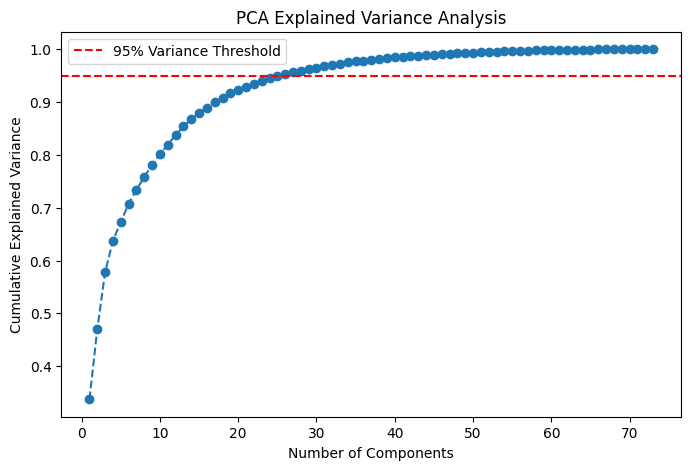

In [3]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Fit PCA on the scaled dataset
pca = PCA()
X_pca_full = pca.fit_transform(X_scaled)

# Explained variance ratio
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker="o", linestyle="--")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance Analysis")
plt.axhline(y=0.95, color="r", linestyle="--", label="95% Variance Threshold")
plt.legend()
plt.show()


In [4]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Select the optimal PCA components (adjust this based on Step 1)
optimal_pca_components = 30  # Change based on explained variance results
pca = PCA(n_components=optimal_pca_components)
X_pca = pca.fit_transform(X_scaled)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_balanced, test_size=0.2, random_state=42)

# Define SVM parameters for tuning
param_grid = {
    "C": [0.1, 1, 10],  # Regularization parameter
    "kernel": ["linear", "poly", "sigmoid", "rbf"],  # Testing multiple kernels
    "degree": [2, 3, 4]  # Only used for polynomial kernel
}

# Perform Grid Search
svm = GridSearchCV(SVC(), param_grid, cv=5, scoring="accuracy", verbose=1)
svm.fit(X_train, y_train)

# Best parameters and performance
print("\n📌 Best SVM Hyperparameters:", svm.best_params_)
y_pred = svm.best_estimator_.predict(X_test)

# Evaluate performance
print("\n📌 Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

print("\n📌 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 36 candidates, totalling 180 fits

📌 Best SVM Hyperparameters: {'C': 10, 'degree': 2, 'kernel': 'rbf'}

📌 Classification Report:
                                    precision    recall  f1-score   support

                Addictive disorder       0.49      0.62      0.55        45
                  Anxiety disorder       0.74      0.86      0.80        59
                   Healthy control       0.76      0.86      0.81        44
                     Mood disorder       0.50      0.17      0.25        47
     Obsessive compulsive disorder       0.95      1.00      0.98        60
                     Schizophrenia       0.75      0.87      0.80        38
Trauma and stress related disorder       0.82      0.74      0.78        57

                          accuracy                           0.74       350
                         macro avg       0.72      0.73      0.71       350
                      weighted avg       0.73      0.74      0.72       350


📌 C